In [1]:
import os
from datetime import datetime
from pathlib import Path
import math
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import functools
import json

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import importlib
import plt_utils as pu
import evaluator as ev
import SMOTER as smtr
import forecasting_models as fmod
import relevance as rlv
import prepare_data as dprep
import GAN as gmod

#allows update import custom modules without having to restart kernel:
importlib.reload(pu)
importlib.reload(ev)
importlib.reload(smtr)
importlib.reload(fmod)
importlib.reload(rlv)
importlib.reload(dprep)
importlib.reload(gmod)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')


LSTM imported successfully!
LSTM imported successfully!


In [2]:
#If tvar and/or fvars not specified it'll just opt for the default specified by meta
def import_data(file_name, tvar=None, fvars=None):
    with open('data/meta.json','r') as file:
        meta = json.load(file)
    meta = meta[file_name]
    ds_name = meta['name']
    if file_name == 'coin_Bitcoin.csv':
        #this dataset is multi-variate, can call this function with specified targets/features or just use defaults
        if not tvar: tvar = meta['tv']
        if not fvars: fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}")
        df=df.reset_index()[fvars if tvar in fvars else [tvar] + fvars]
    else:
        #rest of the datasets are univariate and don't have headers
        tvar = meta['tv']
        fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}", header=None, names=[tvar])
    return df, tvar, fvars, ds_name

#importing london_merged:
DATA_FILE = 'coin_Bitcoin.csv'
df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)


#importing baseline:
#DATA_FILE = 'sunspot.dat'
#df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

N_FVARS = len(FVARS)
print(df1)

             Close
0       144.539993
1       139.000000
2       116.989998
3       105.209999
4        97.750000
...            ...
2986  33897.048590
2987  34668.548402
2988  35287.779766
2989  33746.002456
2990  34235.193451

[2991 rows x 1 columns]


In [3]:
FORECASTERS = ["Quantile_ConvLSTM"]

In [4]:
import recorder as rec
importlib.reload(rec)
to_save = {'forecast_models': False,
           'forecast_results': False,
           'resample_models': False, #best GANs 
           'resample_results': True,
           'eval_results': True, #evaluation metrics
           'logs': True,
           'figures': True,
           'parameters': True,
          }

RECORDER = rec.ExperimentRecorder(to_save, "Bike", FORECASTERS)
#LOADER = rec.ExperimentLoader(to_load, "Bike")
#load results from a previous session to compare with results from this session
#base_results_dir must contain resampling results and eval results to combine results
COMBINE_RESULTS_DIR = None #"Sessions/Bike/2023-October-13 13-41-03-532984"

#set GAN_DIR to none to train a new GAN, else give it a folder path to load from
GAN_CNN_DIR = None
GAN_FNN_DIR = None
#GAN_FNN_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\resample_models")

#set FORECAST_DIR to none to train a new LSTM, else give it a folder path to load from
FORECAST_DIR = None
#FORECAST_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\forecast_models")
loadedModels = {"loadedModels": {"GanCnnDir": GAN_CNN_DIR, "GanFnnDir":GAN_FNN_DIR, "ForecastDir": FORECAST_DIR}}
RECORDER.save_param_dict(loadedModels)

In [5]:
RECORDER.log_print(f"Using data from: {DATA_FILE}")
RECORDER.log_print(f"Using feature variables: {FVARS} to predict target variable: '{TVAR}'")
RECORDER.save_param_dict({"importingData":{"dataFile":DATA_FILE,"targetVar":TVAR,"featVars":FVARS}})

df1 = np.array(df1).reshape(-1,N_FVARS)

scaler=MinMaxScaler(feature_range=(0,1))
df1 = df1.reshape(-1,N_FVARS)
scaled_data = scaler.fit_transform(df1) 
print(f"scaled_data: {scaled_data.shape}")

#Prep Data
N_STEPS_IN = 5
N_STEPS_OUT = 5
SPLIT_RATIO = 0.7
SAMPLE_DIM = N_STEPS_IN*N_FVARS + N_STEPS_OUT

k_X, X_train, Y_train, X_test, Y_test = dprep.split_data(scaled_data, N_STEPS_IN, N_STEPS_OUT, FVARS, N_FVARS, TVAR, SPLIT_RATIO)

RECORDER.save_param_dict({"prepData":{"nStepsIn":N_STEPS_IN,"nStepsOut":N_STEPS_OUT,"splitRatio":SPLIT_RATIO}})
RECORDER.log_print(f"Embedding steps in: {N_STEPS_IN} and steps out: {N_STEPS_OUT}")
RECORDER.log_print(f"Split dataset with training ratio: {SPLIT_RATIO}")
RECORDER.log_print(f"""Split data shapes:\n\t X_train: {X_train.shape}\n\t Y_train: {Y_train.shape}\n\t X_test: {X_test.shape}\n\t Y_test: {Y_test.shape}\n\t k_X: {k_X.shape}""")

LOG: 13:20:32:222 Using data from: coin_Bitcoin.csv

LOG: 13:20:32:224 Using feature variables: ['Close'] to predict target variable: 'Close'

scaled_data: (2991, 1)
LOG: 13:20:32:253 Embedding steps in: 5 and steps out: 5

LOG: 13:20:32:253 Split dataset with training ratio: 0.7

LOG: 13:20:32:253 Split data shapes:
	 X_train: (2087, 5, 1)
	 Y_train: (2087, 5)
	 X_test: (895, 5, 1)
	 Y_test: (895, 5)
	 k_X: (2087, 10)


In [6]:
#give this guy a list of training target values and it will give you a function that you can input target values to get a relevance score
def getPoisRelFunc(y):
    sample_mean = np.mean(y) 
    sample_std = np.std(y)
    rel_quant = np.quantile(1/rlv.dpois(y,sample_mean),0.5)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"Pois","funcParams":{}}})
    return functools.partial(rlv.poisRelevance, smean=sample_mean, sstd=sample_std, rshift=rel_quant)
    
def getPCHIPRelFunc(y, percs, rels):
    pchip = rlv.PCHIP_interpolator(y, percs, rels)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"PCHIP","funcParams":{"percentages":list(percs),"rels":list(rels)}}})
    return functools.partial(rlv.PCHIPRelevance, pchip_func=pchip)

all_train_targets = np.append(Y_train[:,0],Y_train[-1,1:]) 
#RELEVANCE_THRESHOLD = 0.31
#RELEVANCE_FUNCTION = getPoisRelFunc(all_train_targets)
RELEVANCE_THRESHOLD = 0.7
pchip_percentiles = [25,95,99]#[25,50,75,95,99]
pchip_relevances = [0.0,0.75,1.0]#[0.0,0.25,0.5,0.75,1.0]
RELEVANCE_FUNCTION = getPCHIPRelFunc(all_train_targets, pchip_percentiles, pchip_relevances) 
EXTREMES_THRESHOLD = rlv.PCHIPApproxInverse(RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION, 0, 0.99) #target value that intersects with RELEVANCE_THRESHOLD

COMBINE = 'first'
r_Y = RELEVANCE_FUNCTION.__call__(Y_train, combine=COMBINE)
k_Y = [val >= RELEVANCE_THRESHOLD for val in r_Y]

RECORDER.save_param_dict({"relevance":{"relThresh":RELEVANCE_THRESHOLD,"exThresh": EXTREMES_THRESHOLD}})

num_rel=k_Y.count(True)

RECORDER.log_print(f"Relevance function {RELEVANCE_FUNCTION.func.__name__} used with threshold: {RELEVANCE_THRESHOLD}")
RECORDER.log_print(f"Relevance {len(k_Y)-num_rel} common values, {num_rel} relevant values")

r_Y = np.array(r_Y)
k_Y = np.array(k_Y)
k_Xex = k_X[k_Y]
print(f"r_Y: {r_Y.shape}")
#print(r_Y)
print(f"k_Y: {k_Y.shape}")
#print(k_Y)
print(f"k_Xex: {k_Xex.shape}")

LOG: 13:20:38:959 Relevance function PCHIPRelevance used with threshold: 0.7

LOG: 13:20:38:960 Relevance 1951 common values, 136 relevant values

r_Y: (2087,)
k_Y: (2087,)
k_Xex: (136, 10)


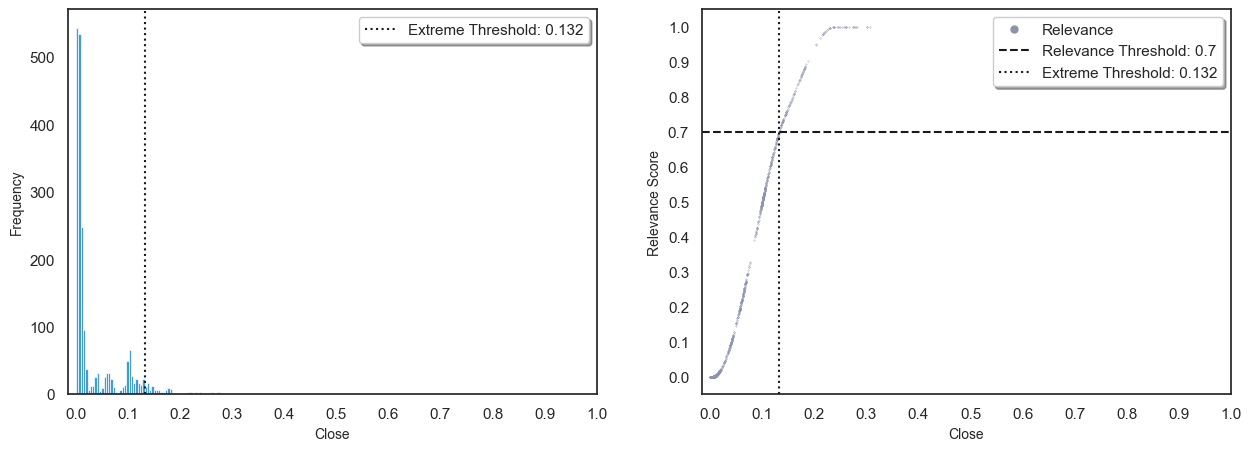

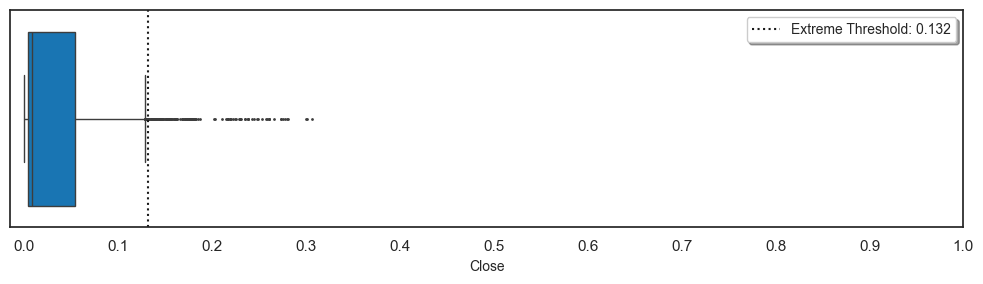

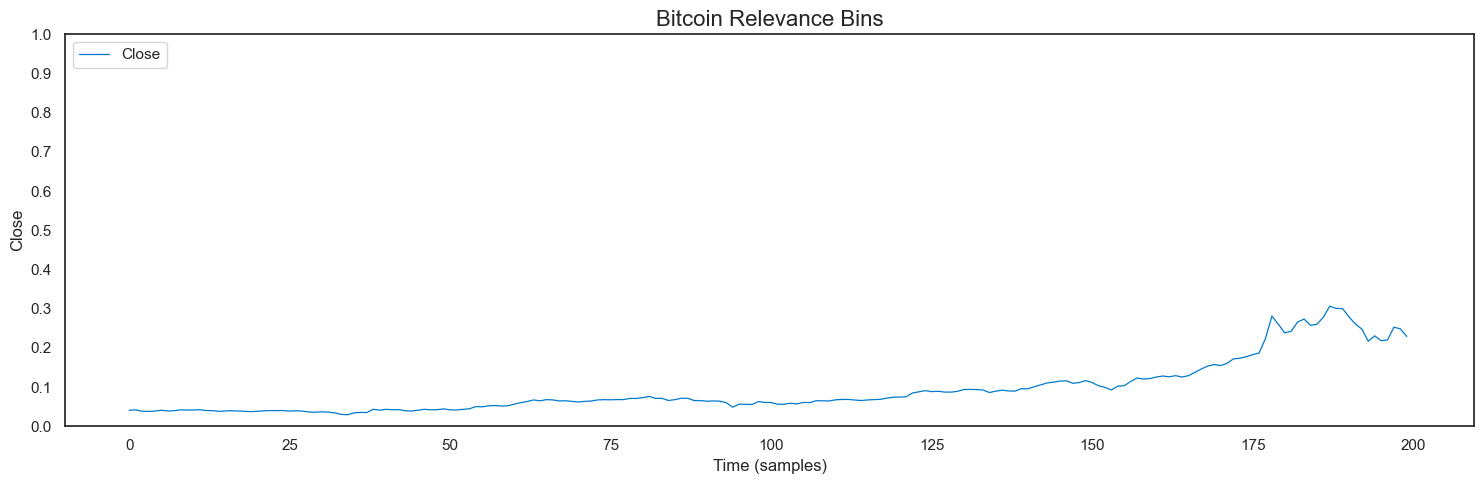

In [7]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)

#pu.PlotScaledData(data, TVAR)

r_Y_plot = RELEVANCE_FUNCTION.__call__(all_train_targets, combine=COMBINE) #relevance for plotting
k_Y_plot = [val >= RELEVANCE_THRESHOLD for val in r_Y_plot]
r_Y_plot = np.array(r_Y_plot)
k_Y_plot = np.array(k_Y_plot)

pu.PlotRelevance(all_train_targets, r_Y_plot, RELEVANCE_THRESHOLD, EXTREMES_THRESHOLD, TVAR, DATA_NAME)

#pu.PlotCaseWeightSurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)
#pu.PlotUtilitySurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)

#pu.PlotBins(all_train_targets,k_Y_plot,EXTREMES_THRESHOLD, TVAR, DATA_NAME)
pu.PlotBins(all_train_targets[1500:1700],k_Y_plot[1500:1700],EXTREMES_THRESHOLD, TVAR, DATA_NAME)

In [8]:
RES_STRATS = ["SMOTER_regular", "SMOTER_bin"]# "SMOTER_bin_t", "SMOTER_bin_r", "SMOTER_bin_tr", "GAN_CNN", "GAN_FNN"]

In [9]:
import SMOTER as smtr
importlib.reload(smtr)

#import GAN as gmod
#importlib.reload(gmod)

K_SMOTE_NEIGHBORS = 3

def run_resampling(k_x, k_y, r_y, res_strats, relevance_function, relevance_threshold, combine):
    resampling_results = {}    
    _, orig_rels, orig_coms = smtr.countRelVsCom(k_x[:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    print(f"need to gen {orig_coms - orig_rels} new rares ontop of current {orig_rels} rares to meet {orig_coms} coms")
    #Perform each variation of each resampling approach
    if "SMOTER_bin" in res_strats:
        resampling_results['SMOTER_bin'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS)
        RECORDER.log_print(f"Finished SMOTER_bin resample")
    if "SMOTER_bin_t" in res_strats:
        resampling_results["SMOTER_bin_t"] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_t resample")
    if "SMOTER_bin_r" in res_strats:
        resampling_results['SMOTER_bin_r'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=False, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_r resample")
    if "SMOTER_bin_tr" in res_strats:
        resampling_results['SMOTER_bin_tr'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_tr resample")
    #We want all the resampling approaches to return the same number of relevance and common cases:
    _, num_rel, num_com = smtr.countRelVsCom(resampling_results['SMOTER_bin'][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    #print(f"num relevance that reg approach is trying to match {num_rel}")
    if "GAN_CNN" in res_strats:
        for key, gen in CNN_GENS.items():
            #resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "CNN") #for testing
            resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "CNN")
            RECORDER.log_print(f"Finished GAN_CNN_e{key}")
    if "GAN_FNN" in res_strats:
        for key, gen in FNN_GENS.items():
            #resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "FNN") #for testing
            resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "FNN")
            RECORDER.log_print(f"Finished GAN_FNN_e{key}")
        
    if "SMOTER_regular" in res_strats:
        resampling_results['SMOTER_regular'], yyyy = smtr.regularResample(k_x, k_y, orig_coms, num_com, K_SMOTE_NEIGHBORS)
        RECORDER.log_print("Finished SMOTER_regular")
    strat_meta = [['Resampling Method','Num Relevant','Num Common','Total']]
    for strat in resampling_results.keys():
        tot, num_rel, num_com = smtr.countRelVsCom(resampling_results[strat][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
        tab_row = [strat,str(num_rel),str(num_com),str(tot)]
        strat_meta.append(tab_row)
    tab_row = ["no_resample",str(orig_rels),str(orig_coms),str(orig_rels+orig_coms)]
    strat_meta.append(tab_row)
    
    RECORDER.log_print("Resampled sizes: \n"+tabulate(strat_meta,headers='firstrow',tablefmt='grid'))
    #RECORDER.save_sample_results_step(resampling_results, N_STEPS_IN, N_FVARS, FVARS, TVAR)
    RECORDER.save_param_dict({"SMOTE":{"kNeighbors":K_SMOTE_NEIGHBORS}})
    
    return resampling_results


#(i moved where we define RES_STRATS to be before we train the GANS)
resampling_results = run_resampling(k_X, k_Y, r_Y, RES_STRATS, RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, COMBINE)

need to gen 1815 new rares ontop of current 136 rares to meet 1951 coms
LOG: 13:20:56:302 Finished SMOTER_bin resample

LOG: 13:20:56:307 Finished SMOTER_regular

LOG: 13:20:56:311 Resampled sizes: 
+---------------------+----------------+--------------+---------+
| Resampling Method   |   Num Relevant |   Num Common |   Total |
+=====================+================+==============+=========+
| SMOTER_bin          |           1948 |         1951 |    3899 |
+---------------------+----------------+--------------+---------+
| SMOTER_regular      |           1951 |         1951 |    3902 |
+---------------------+----------------+--------------+---------+
| no_resample         |            136 |         1951 |    2087 |
+---------------------+----------------+--------------+---------+


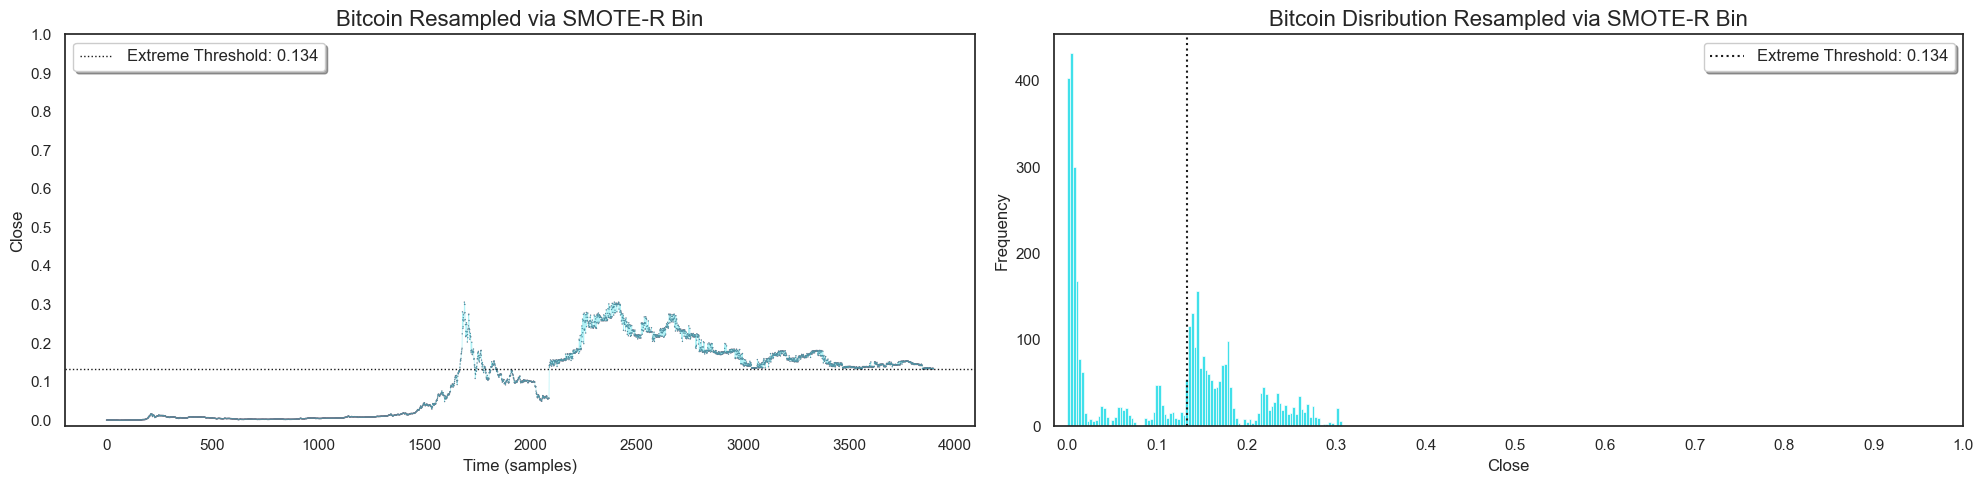

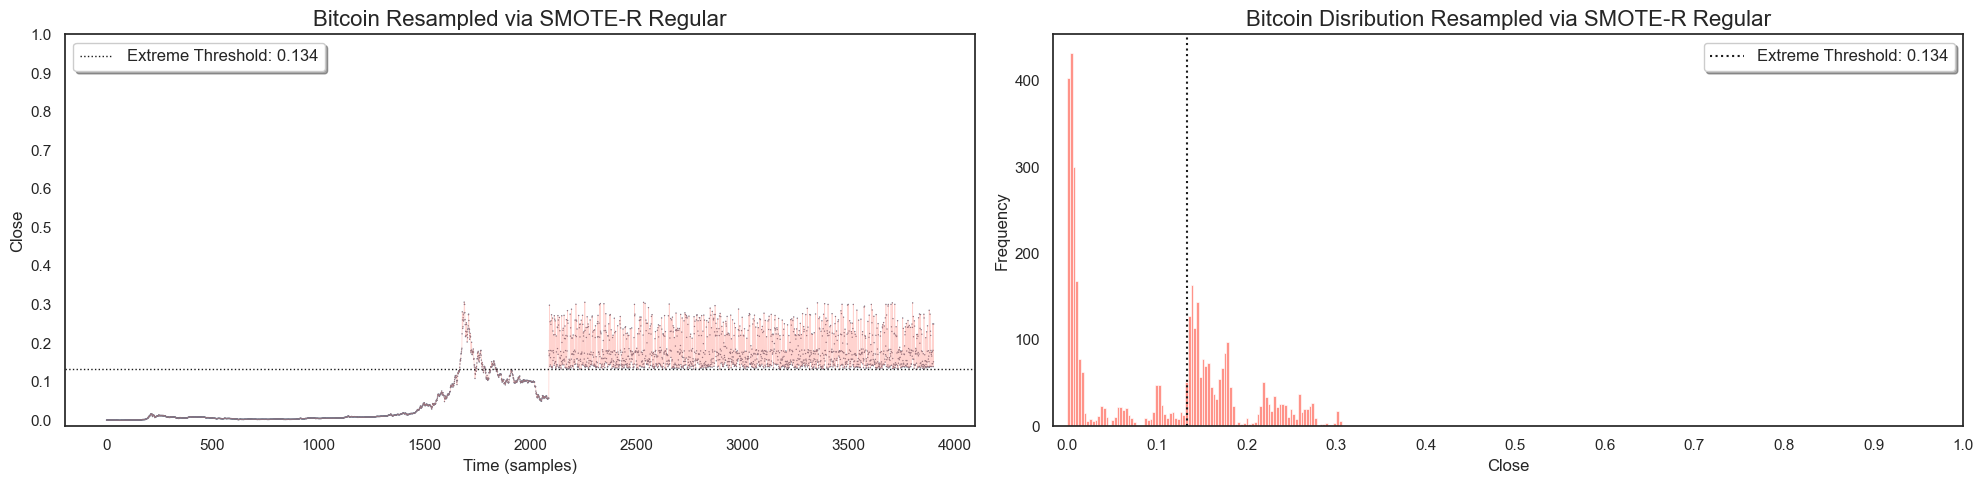

In [11]:
#import plt_utils as pu
#importlib.reload(pu)
#only plots first step out in each embedded
pu.PlotResampledResults(resampling_results, k_X.shape[0], N_STEPS_OUT,EXTREMES_THRESHOLD, TVAR, DATA_NAME)

In [14]:
import evaluator as ev
importlib.reload(ev)

#NOTE: evaler_params must include CaseWeight else errors in MODEL_LSTM
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "SER": {},
                     "Utility": {'m':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {},
                     "FScore": {'beta':0.5},
                     #"RelevanceROC": {},
                   }
EVALERS = {}
for f in FORECASTERS:
    EVALERS[f] = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

#EVALER = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)
RECORDER.save_param_dict({"Evaluator":evaluator_params})

In [15]:
NUM_EXPERIMENTS = 10

def main(time_step, X_train, X_test, Y_train, Y_test, resampling_results, evalers, recorder, train_params):   
    recorder.log_print(f"Starting forecasting experiments with num_exps: {train_params['num_exp']} and epochs: {train_params['epochs']}")
    recorder.save_param_dict({"Forecasting":{"NumExp":train_params['num_exp'], "nEpochs": train_params['epochs'], "hidden":train_params['hidden']}})
    
    forecast_results = {}
    for f in FORECASTERS:
        print(f"############## no_resample : {f} ##############")
        if f == "Quantile_ConvLSTM":
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_QUANTILE_CONV_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
        else:
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_BD_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
    
        results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_train,'Y_train':Y_train,'model':best_model}
        forecast_results[f] = {}
        forecast_results[f]['no_resample'] = results
    
    
    for key in resampling_results.keys():
        res = resampling_results[key]
        X_res = res[:,:(N_STEPS_IN*N_FVARS)]
        X_res = X_res.reshape((X_res.shape[0],N_STEPS_IN,N_FVARS))
        Y_res = res[:,(N_STEPS_IN*N_FVARS):]
        for f in FORECASTERS:
            print(f"############## {key} : {f} ##############")
            if f == "Quantile_ConvLSTM":
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_QUANTILE_CONV_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
            else:
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_BD_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
        
            results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_res,'Y_train':Y_res,'model':best_model}
            forecast_results[f][key] = results
    
    return forecast_results

TRAIN_PARAMS = {
        'num_exp': NUM_EXPERIMENTS, 
        'n_steps_in': N_STEPS_IN,
        'n_steps_out': N_STEPS_OUT,
        'epochs': 30,
        'hidden': 100,
        'forecast_dir': FORECAST_DIR,
        'n_fvars': N_FVARS
    }

forecast_results = main(N_STEPS_IN, X_train, X_test, Y_train, Y_test, resampling_results, EVALERS, RECORDER, TRAIN_PARAMS)

print("$$$$ FINISHED FORECASTING EXPERIMENTS $$$$")

LOG: 13:23:27:206 Starting forecasting experiments with num_exps: 10 and epochs: 30

############## no_resample : Quantile_ConvLSTM ##############
LOG: 13:23:27:408 ====== Running Quantile Conv-LSTM [no_resample] ======

LOG: 13:23:27:408 	Experiment 1 in progress
LOG: 13:23:55:175 	Experiment 2 in progress
LOG: 13:24:18:881 	Experiment 3 in progress
LOG: 13:24:42:621 	Experiment 4 in progress
LOG: 13:25:05:908 	Experiment 5 in progress
LOG: 13:25:29:225 	Experiment 6 in progress
LOG: 13:25:52:182 	Experiment 7 in progress
LOG: 13:26:15:181 	Experiment 8 in progress
LOG: 13:26:38:141 	Experiment 9 in progress
LOG: 13:27:01:479 	Experiment 10 in progress
############## SMOTER_bin : Quantile_ConvLSTM ##############
LOG: 13:27:24:856 ====== Running Quantile Conv-LSTM [SMOTER_bin] ======

LOG: 13:27:24:856 	Experiment 1 in progress
LOG: 13:28:10:020 	Experiment 2 in progress
LOG: 13:28:52:419 	Experiment 3 in progress
LOG: 13:29:34:654 	Experiment 4 in progress
LOG: 13:30:17:569 	Experimen

In [16]:
for f in FORECASTERS:
    RECORDER.save_all_evaler_exps(EVALERS[f].getResultsDf(), f)

In [17]:
import numpy as np
import pandas as pd

# ❶ 把想看的模型换成 "Conv_LSTM" / "BD_LSTM" / "Quantile_ConvLSTM"
df = EVALERS["Quantile_ConvLSTM"].getResultsDf().copy()

# ❷ 解析出 “重采样策略” 与 “分位数标签”
tmp = df["Res"].str.rsplit("_", n=1, expand=True)
df["Resample"] = tmp[0]                 # 例如 no_resample / SMOTER_bin
df["Quantile"] = tmp[1].where(tmp[1].isin(["q05","q50","q95"]),
                              "q50")     # 防守式回填，可忽略

# ❸ 只保留 SER 与 RMSE_Test 列（根据你的列名适配）
metric_cols = (df.filter(like="SER").columns
               .tolist() + df.filter(like="RMSE_Test").columns.tolist())

# ❹ 若列里存的是 array，把它们缩并成均值
for c in metric_cols:
    df[c] = df[c].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# ❺ 按 [Resample, Quantile] 分组，再汇总均值 ± 标准差
grouped   = df.groupby(["Resample", "Quantile"])
mean_df   = grouped[metric_cols].mean()
std_df    = grouped[metric_cols].std()

summary = mean_df.round(4).astype(str) + " ± " + std_df.round(4).astype(str)
summary



RMSERare_Train  SER_Train    RMSERare_Test  \
Resample       Quantile                                                
SMOTER_bin     q05        0.034 ± 0.0062  nan ± nan   0.137 ± 0.0258   
               q50       0.0221 ± 0.0034  nan ± nan   0.1337 ± 0.076   
               q95       0.0387 ± 0.0067  nan ± nan  0.1084 ± 0.0903   
SMOTER_regular q05       0.0311 ± 0.0032  nan ± nan   0.2816 ± 0.173   
               q50       0.0171 ± 0.0027  nan ± nan   0.364 ± 0.1469   
               q95         0.036 ± 0.003  nan ± nan  0.3395 ± 0.2148   
no_resample    q05       0.0461 ± 0.0104  nan ± nan  0.1827 ± 0.0184   
               q50       0.0234 ± 0.0019  nan ± nan  0.2101 ± 0.1319   
               q95       0.0494 ± 0.0141  nan ± nan  0.1646 ± 0.1443   

                          SER_Test      SER1%_Train      SER2%_Train  \
Resample       Quantile                                                
SMOTER_bin     q05       nan ± nan  0.0135 ± 0.0061  0.0167 ± 0.0124   
               q50       nan ± nan   0.028 ± 0.0018  0.0286 ± 0.0028   
               q95       nan ± nan   0.0496 ± 0.007   0.0496 ± 0.007   
SMOTER_regular q05       nan ± nan  0.0153 ± 0.0032  0.0153 ± 0.0033   
               q50       nan ± nan  0.0165 ± 0.0033  0.0165 ± 0.0033   
               q95       nan ± nan  0.0516 ± 0.0027  0.0516 ± 0.0027   
no_resample    q05       nan ± nan  0.0247 ± 0.0226  0.0265 ± 0.0243   
               q50       nan ± nan  0.0329 ± 0.0027  0.0315 ± 0.0027   
               q95       nan ± nan  0.0687 ± 0.0167  0.0687 ± 0.0167   

                             SER5%_Train     SER10%_Train     SER25%_Train  \
Resample       Quantile                                                      
SMOTER_bin     q05       0.0176 ± 0.0141  0.0215 ± 0.0165  0.0346 ± 0.0099   
               q50       0.0307 ± 0.0057  0.0282 ± 0.0053  0.0283 ± 0.0042   
               q95        0.0496 ± 0.007   0.0496 ± 0.007  0.0488 ± 0.0068   
SMOTER_regular q05       0.0184 ± 0.0076  0.0247 ± 0.0117  0.0334 ± 0.0065   
               q50       0.0165 ± 0.0033  0.0165 ± 0.0032  0.0203 ± 0.0028   
               q95       0.0516 ± 0.0027  0.0516 ± 0.0027  0.0479 ± 0.0031   
no_resample    q05       0.0284 ± 0.0175  0.0242 ± 0.0135  0.0239 ± 0.0033   
               q50       0.0271 ± 0.0024  0.0209 ± 0.0019  0.0146 ± 0.0016   
               q95       0.0575 ± 0.0156   0.046 ± 0.0139  0.0331 ± 0.0122   

                            SER50%_Train     SER75%_Train       SER1%_Test  \
Resample       Quantile                                                      
SMOTER_bin     q05       0.0325 ± 0.0061  0.0283 ± 0.0048  0.2327 ± 0.0446   
               q50        0.022 ± 0.0032  0.0191 ± 0.0027  0.2168 ± 0.1203   
               q95       0.0407 ± 0.0069   0.036 ± 0.0079  0.1552 ± 0.1313   
SMOTER_regular q05         0.03 ± 0.0031  0.0256 ± 0.0027  0.4988 ± 0.3112   
               q50       0.0171 ± 0.0026  0.0148 ± 0.0023   0.6832 ± 0.292   
               q95       0.0372 ± 0.0034  0.0321 ± 0.0038  0.5597 ± 0.3923   
no_resample    q05       0.0184 ± 0.0027  0.0157 ± 0.0051   0.3179 ± 0.034   
               q50       0.0116 ± 0.0017  0.0103 ± 0.0017  0.3053 ± 0.2222   
               q95       0.0256 ± 0.0107  0.0219 ± 0.0102  0.2421 ± 0.1916   

                              SER2%_Test       SER5%_Test      SER10%_Test  \
Resample       Quantile                                                      
SMOTER_bin     q05       0.2327 ± 0.0446  0.2327 ± 0.0446  0.2327 ± 0.0446   
               q50       0.2168 ± 0.1203  0.2168 ± 0.1203  0.2168 ± 0.1203   
               q95       0.1552 ± 0.1313  0.1552 ± 0.1313  0.1552 ± 0.1313   
SMOTER_regular q05       0.4988 ± 0.3112  0.4988 ± 0.3112  0.4988 ± 0.3112   
               q50        0.6832 ± 0.292   0.6832 ± 0.292   0.6832 ± 0.292   
               q95       0.5597 ± 0.3923  0.5597 ± 0.3923  0.5597 ± 0.3923   
no_resample    q05        0.3179 ± 0.034   0.3179 ± 0.034   0.3179 ± 0.034   
               q50  

In [23]:
df2 = EVALERS["BD_LSTM"].getResultsDf()

# 只选 SER 和 RMSE_Test 相关列
cols = df2.filter(like="SER").columns.tolist() + df2.filter(like="RMSE_Test").columns.tolist()
ser_rmse_df = df2[["Res"] + cols]  # ⬅️ 加上 Res 列

# 展开 SER 中的 array，取均值
ser_rmse_df[cols] = ser_rmse_df[cols].applymap(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# 按 Res 分组，计算均值和标准差
grouped = ser_rmse_df.groupby("Res")
mean_df = grouped.mean()
std_df = grouped.std()

# 拼成 "均值 ± 标准差" 格式
summary2 = mean_df.round(4).astype(str) + " ± " + std_df.round(4).astype(str)
summary2

,RMSERare_Train,SER_Train,RMSERare_Test,SER_Test,SER1%_Train,SER2%_Train,SER5%_Train,SER10%_Train,SER25%_Train,SER50%_Train,SER75%_Train,SER1%_Test,SER2%_Test,SER5%_Test,SER10%_Test,SER25%_Test,SER50%_Test,SER75%_Test,RMSE_Test
Res,,,,,,,,,,,,,,,,,,,
SMOTER_bin,0.0303 ± 0.0118,nan ± nan,0.6474 ± 0.4794,nan ± nan,0.0372 ± 0.0214,0.0379 ± 0.0181,0.0423 ± 0.0173,0.0385 ± 0.0162,0.0378 ± 0.012,0.03 ± 0.0115,0.0287 ± 0.0151,1.2018 ± 0.8687,1.2018 ± 0.8687,1.2018 ± 0.8687,1.2018 ± 0.8687,1.1557 ± 0.8568,0.818 ± 0.6053,0.6682 ± 0.4941,0.5392 ± 0.3987
SMOTER_regular,0.0218 ± 0.0087,nan ± nan,0.5814 ± 0.4717,nan ± nan,0.0284 ± 0.0152,0.0288 ± 0.0164,0.0289 ± 0.0168,0.0284 ± 0.0173,0.0284 ± 0.0115,0.0222 ± 0.0085,0.0216 ± 0.0154,1.0718 ± 0.9328,1.0718 ± 0.9328,1.0718 ± 0.9328,1.0718 ± 0.9328,1.0194 ± 0.8897,0.7292 ± 0.6227,0.5985 ± 0.5066,0.4842 ± 0.3925
no_resample,0.0379 ± 0.0343,nan ± nan,0.1358 ± 0.0917,nan ± nan,0.0498 ± 0.0399,0.0479 ± 0.0349,0.0397 ± 0.0258,0.0316 ± 0.0226,0.0225 ± 0.0168,0.0184 ± 0.0134,0.0164 ± 0.013,0.2362 ± 0.1922,0.2357 ± 0.1905,0.2317 ± 0.1783,0.2274 ± 0.1655,0.2152 ± 0.1303,0.1574 ± 0.0936,0.1312 ± 0.0825,0.1135 ± 0.0766
